In [1]:
import os, json, sys, glob, time, math
import torch

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from pytorch3d.structures import Volumes
from pytorch3d.renderer import (
FoVPerspectiveCameras, VolumeRenderer,
NDCGridRaysampler, EmissionAbsorptionRaymarcher
)

from pytorch3d.transforms import so3_exp_map

from plot_image_grid import image_grid
from generate_cow_renders import generate_cow_renders

In [2]:
from tqdm import tqdm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
target_cameras, target_images, target_silhouttes = generate_cow_renders(num_views = 40)

In [ ]:
render_size = 128
volume_extent_world = 3.0
raysampler = NDCGridRaysampler(
    image_width = render_size,
    image_height = render_size,
    n_pts_per_ray = 150,
    min_depth = 0.1,
    max_depth = volume_extent_world,
)

In [ ]:
raymarcher = EmissionAbsorptionRaymarcher()
renderer = VolumeRenderer(
    raysampler=raysampler,
    raymarcher=raymarcher,
)

In [8]:
class VolumeModel(torch.nn.Module):
    def __init__(self, renderer, volume_size = [64] * 3, voxel_size = 0.1):
        super().__init__()
        
        self.log_densities = torch.nn.Parameter(
            -4.0 * torch.ones(1, *volume_size)
        )
        self.log_colors = torch.nn.Parameter(
            torch.zeros(3, *volume_size)
        )
        self._voxel_size = voxel_size
        self._renderer = renderer

    def forward(self, cameras):
        batch_size = cameras.R.shape[0]
        densities = torch.sigmoid(self.log_densities)
        colors = torch.sigmoid(self.log_colors)
        volumes = Volumes(
            densities = densities.unsqueeze(0).expand(
                batch_size, *self.log_densities.shape
            ),
            features = colors.unsqueeze(0).expand(
                batch_size, *self.log_colors.shape
            ),
            voxel_size = self._voxel_size
        )

        return self._renderer(cameras=cameras, volumes=volumes)[0]

In [9]:
# лось
def huber(x, y, scaling=0.1):
    diff_sq = (x-y) ** 2
    loss = ((1 + diff_sq / (scaling ** 2)).clamp(1e-4).sqrt() - 1) * float(scaling)
    return loss

In [10]:
target_cameras = target_cameras.to(device)
target_images = target_images.to(device)
target_silhouttes = target_silhouttes.to(device)

In [11]:
volume_size = 128
volume_model = VolumeModel(
    renderer,
    volume_size = [volume_size] * 3,
    voxel_size = volume_extent_world / volume_size
).to(device)

In [12]:
volume_model

VolumeModel(
  (_renderer): VolumeRenderer(
    (renderer): ImplicitRenderer(
      (raysampler): NDCMultinomialRaysampler()
      (raymarcher): EmissionAbsorptionRaymarcher()
    )
  )
)

In [13]:
optimizer = torch.optim.Adam(volume_model.parameters())

In [14]:
lr = 0.1
batch_size = 10
n_iter = 300

In [20]:
cow_forming_images = list()
i = 0

volume_model.train()
for iteration in tqdm(range(n_iter)):
    volume_model.train()
    if iteration == round(n_iter * 0.75):
        optimizer = torch.optim.Adam(volume_model.parameters(), lr = lr * 0.1)

    # forward pass
    batch_idx = torch.randperm(len(target_cameras))[:batch_size]

    batch_cameras = FoVPerspectiveCameras(
        R = target_cameras.R[batch_idx],
        T = target_cameras.T[batch_idx],
        zfar = target_cameras.zfar[batch_idx],
        aspect_ratio = target_cameras.aspect_ratio[batch_idx],
        fov = target_cameras.fov[batch_idx],
        device = device
    )

    rendered_images, rendered_silhouttes = volume_model(batch_cameras).split([3, 1], dim = -1)

    # calculating the loss
    sil_err = huber(
        rendered_silhouttes[..., 0],
        target_silhouttes[batch_idx]
    ).abs().mean()

    color_err = huber(
        rendered_images,
        target_images[batch_idx]
    ).abs().mean()

    loss = color_err + sil_err

    # rest is following
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    volume_model.eval()
    with torch.no_grad():
        rendered_images_eval, rendered_silhouttes_eval = volume_model(target_cameras[i]).split([3, 1], dim = -1)
        cow_forming_images.append(rendered_images_eval.squeeze().cpu().numpy())
        i = i + 1 if i < len(target_cameras) - 1 else 0
    

torch.save(volume_model.state_dict(), './volume_model.pth')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:22<00:00,  3.63it/s]


In [21]:
import imageio
from skimage import img_as_ubyte

imgs = list()
for img in cow_forming_images:
    imgs.append(img_as_ubyte(img))
    
imageio.mimsave('cow_forming_128_600-900_epochs.gif', imgs)

In [32]:
volume_size = 128
volume_model = VolumeModel(
    renderer,
    volume_size = [volume_size] * 3,
    voxel_size = volume_extent_world / volume_size
)
volume_model.load_state_dict(torch.load('./volume_model.pth', weights_only=True))
volume_model = volume_model.to(device)
volume_model

VolumeModel(
  (_renderer): VolumeRenderer(
    (renderer): ImplicitRenderer(
      (raysampler): NDCMultinomialRaysampler()
      (raymarcher): EmissionAbsorptionRaymarcher()
    )
  )
)

In [16]:
rendered_images_final = list()
rendered_silhouttes_final = list()


volume_model.eval()
with torch.no_grad():
    for i in tqdm(range(len(target_cameras))):
        rendered_images_eval, rendered_silhouttes_eval = volume_model(target_cameras[i]).split([3, 1], dim = -1)
        rendered_images_final.append(rendered_images_eval.squeeze().cpu().numpy())
        rendered_silhouttes_final.append(rendered_silhouttes_eval.squeeze().cpu().numpy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.35it/s]


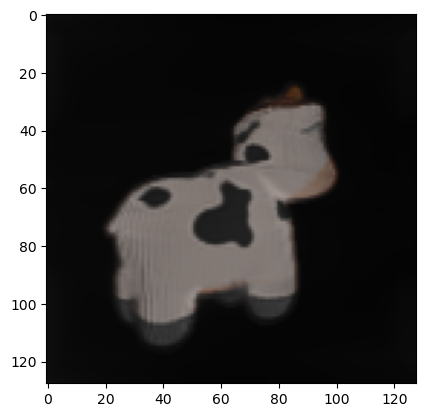

In [17]:
rendered_images_final[0].shape
plt.imshow(rendered_images_final[6])

In [19]:
import imageio
from skimage import img_as_ubyte

imgs = list()
for img in rendered_images_final:
    imgs.append(img_as_ubyte(img))
    
imageio.mimsave('cow_volume_128.gif', imgs)

In [31]:
imgs = list()
for img in rendered_silhouttes_final:
    imgs.append(img_as_ubyte(img))
    
imageio.mimsave('cow_volume_silhouette_128.gif', imgs)

In [22]:
torch.Tensor(rendered_silhouttes_final).shape

torch.Size([40, 128, 128])

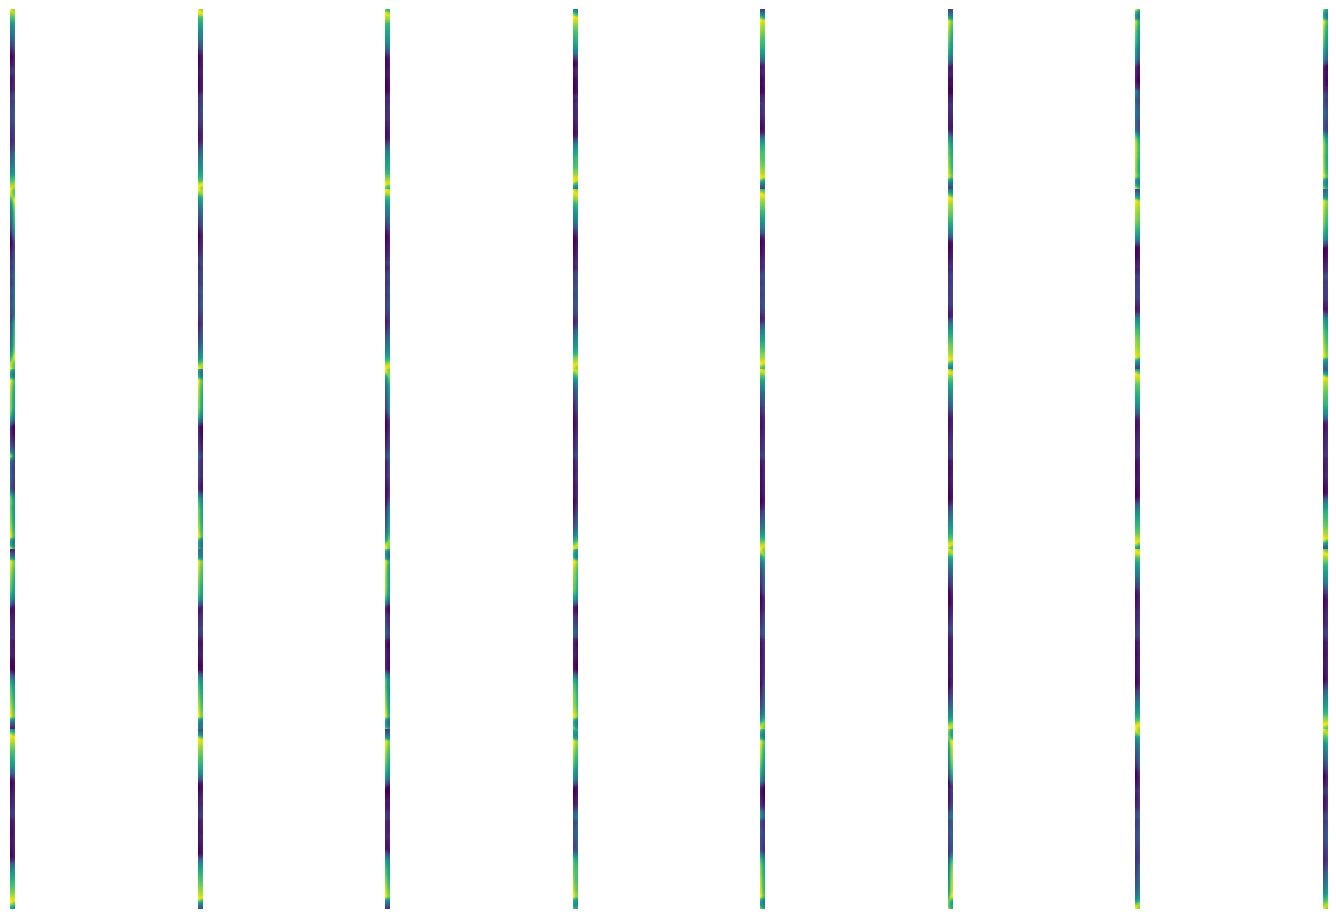

In [30]:
# with torch.no_grad():
#     rotating_volume_frames = generate_rotating_volume(volume_model, n_frames = 7 * 4)



image_grid(torch.Tensor(rendered_silhouttes_final).clamp(0., 1.).numpy(), rows=5, cols=8, rgb=True, fill=True)
plt.savefig('rotating_volume.png')
plt.show()